In [1]:
import pandas as pd
import numpy as np
from google.colab import files
uploaded=files.upload()

Saving diabetes.csv to diabetes.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df=pd.read_csv("diabetes.csv")
df.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
df.shape,df.dtypes

((768, 9),
 Pregnancies                   int64
 Glucose                       int64
 BloodPressure                 int64
 SkinThickness                 int64
 Insulin                       int64
 BMI                         float64
 DiabetesPedigreeFunction    float64
 Age                           int64
 Outcome                       int64
 dtype: object)

In [ ]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [4]:
df.Outcome.value_counts(normalize=True)

,proportion
Outcome,
0,0.651042
1,0.348958


In [5]:
zero_cols=["Glucose","BloodPressure","SkinThickness","Insulin","BMI"]
(df[zero_cols]==0).sum()

,0
Glucose,5
BloodPressure,35
SkinThickness,227
Insulin,374
BMI,11


<Axes: xlabel='Glucose', ylabel='Count'>

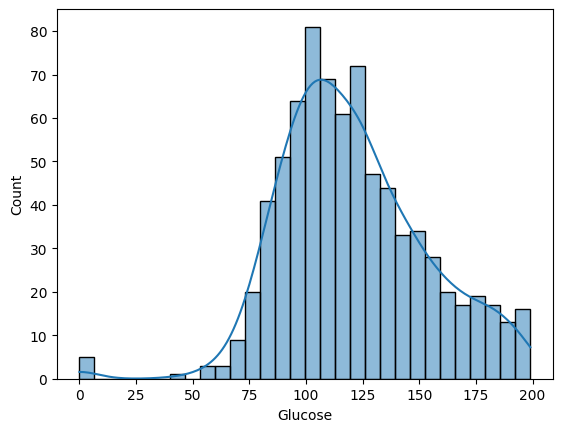

In [ ]:
sns.histplot(df.Glucose.dropna(), bins=30, kde=True)

<Axes: ylabel='Glucose'>

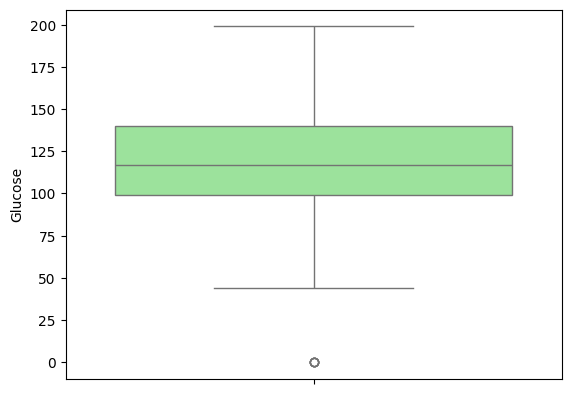

In [ ]:
sns.boxplot(y=df['Glucose'].dropna(), color='lightgreen')

<Axes: xlabel='BMI', ylabel='Count'>

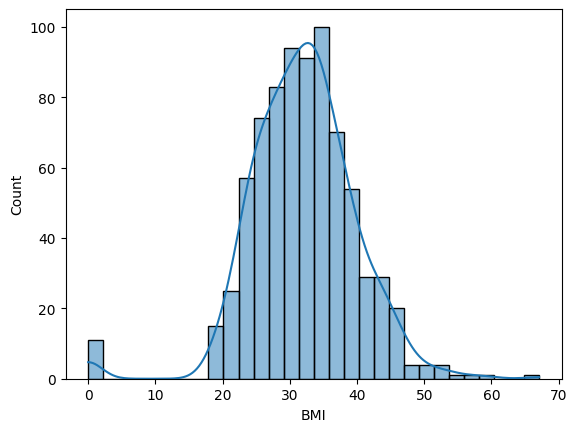

In [ ]:
sns.histplot(df['BMI'].dropna(), bins=30, kde=True)

<Axes: ylabel='BMI'>

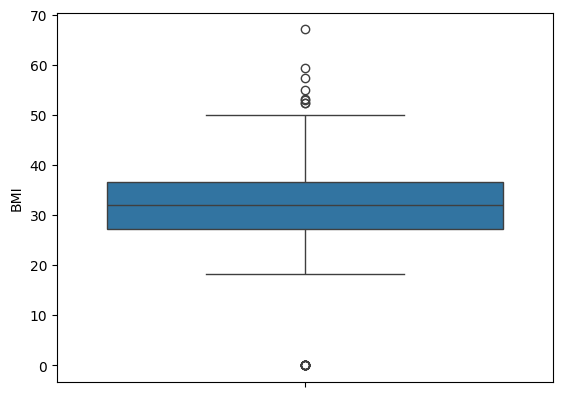

In [ ]:
sns.boxplot(y=df['BMI'].dropna())

In [6]:
cols_bad=["Glucose","BloodPressure","SkinThickness","Insulin","BMI"]
for c in cols_bad:
  df[c]=df[c].replace(0,np.nan)
impute_counts=df[cols_bad].isna().sum()
df[cols_bad]=df[cols_bad].fillna(df[cols_bad].median())
df.isna().sum,impute_counts

(<bound method DataFrame.sum of      Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  \
 0          False    False          False          False    False  False   
 1          False    False          False          False    False  False   
 2          False    False          False          False    False  False   
 3          False    False          False          False    False  False   
 4          False    False          False          False    False  False   
 ..           ...      ...            ...            ...      ...    ...   
 763        False    False          False          False    False  False   
 764        False    False          False          False    False  False   
 765        False    False          False          False    False  False   
 766        False    False          False          False    False  False   
 767        False    False          False          False    False  False   
 
      DiabetesPedigreeFunction    Age  Outcome  
 0    

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,roc_auc_score

x=df.drop("Outcome",axis=1)
y=df["Outcome"]
x_train,x_test,y_train,y_test=train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

In [10]:
scaler=StandardScaler()
x_train_s=scaler.fit_transform(x_train)
x_test_s=scaler.transform(x_test)

lr=LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
lr.fit(x_train_s, y_train)
y_pred=lr.predict(x_test_s)
proba=lr.predict_proba(x_test_s)[:,1]
print(classification_report(y_test,y_pred))
print("ROC-AUC:",roc_auc_score(y_test,proba))


              precision    recall  f1-score   support

           0       0.82      0.75      0.79       100
           1       0.60      0.70      0.65        54

    accuracy                           0.73       154
   macro avg       0.71      0.73      0.72       154
weighted avg       0.75      0.73      0.74       154

ROC-AUC: 0.8125925925925926


In [13]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import precision_recall_fscore_support,roc_curve,auc

sm=SMOTE(random_state=42)
x_train_sm,y_train_sm=sm.fit_resample(x_train_s,y_train)
models={
    "LogReg": lr,
    "RandomForest": RandomForestClassifier(n_estimators=300, class_weight="balanced", random_state=42),
    "GradBoost": GradientBoostingClassifier(random_state=42)
}
for name, m in models.items():
    if name=="LogReg":
        m.fit(x_train_s, y_train)
        p = m.predict(x_test_s); pr = m.predict_proba(x_test_s)[:,1]
    else:
        m.fit(x_train_sm, y_train_sm)
        p = m.predict(x_test_s); pr = m.predict_proba(x_test_s)[:,1]
    prec, rec, f1, _ = precision_recall_fscore_support(y_test, p, average="binary")
    print(name, "AUC:", roc_auc_score(y_test, pr), "| P/R/F1:", round(prec,3), round(rec,3), round(f1,3))



LogReg AUC: 0.8125925925925926 | P/R/F1: 0.603 0.704 0.65
RandomForest AUC: 0.8153703703703704 | P/R/F1: 0.623 0.704 0.661
GradBoost AUC: 0.8212962962962963 | P/R/F1: 0.641 0.759 0.695


In [15]:
from sklearn.model_selection import StratifiedKFold,GridSearchCV
gb=GradientBoostingClassifier(random_state=42)
grid={"n_estimators":[200,400,600],
    "max_depth":[None,5,10],
    "min_samples_split":[2,5,10]}
cv=StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
gs=GridSearchCV(gb,grid,cv=cv,scoring="roc_auc",n_jobs=-1)
gs.fit(x_train_sm,y_train_sm)
print(gs.best_params_)
best=gs.best_estimator_
print("Test AUC:", roc_auc_score(y_test, best.predict_proba(x_test_s)[:,1]))


{'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 400}
Test AUC: 0.7996296296296296


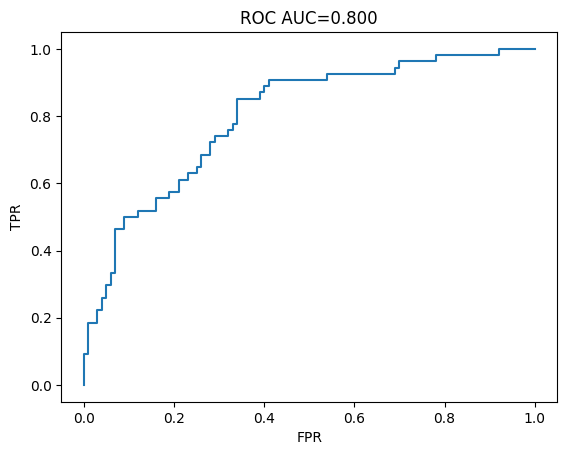

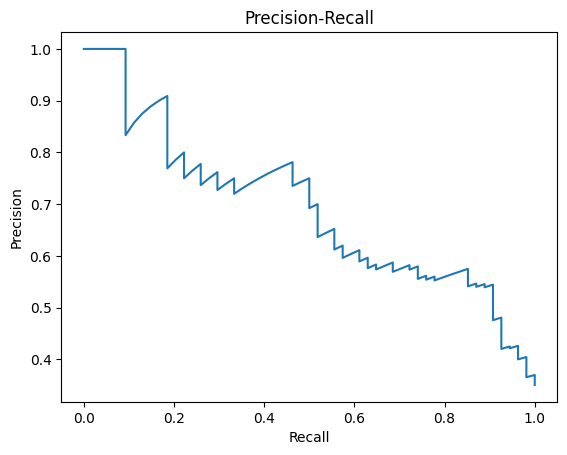

np.float64(0.0061764097552484435)

In [19]:
from sklearn.metrics import roc_curve,precision_recall_curve,auc
proba=best.predict_proba(x_test_s)[:,1]
fpr,tpr,_=roc_curve(y_test,proba)
roc_auc=auc(fpr,tpr)
prec,rec,thr=precision_recall_curve(y_test,proba)
plt.figure(); plt.plot(fpr,tpr); plt.title(f"ROC AUC={roc_auc:.3f}"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.show()
plt.figure(); plt.plot(rec,prec); plt.title("Precision-Recall"); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.show()

target_recall=0.80
idx=np.where(rec>=target_recall)[0][-1]
chosen_thr=thr[idx] if idx<len(thr) else 0.5
chosen_thr

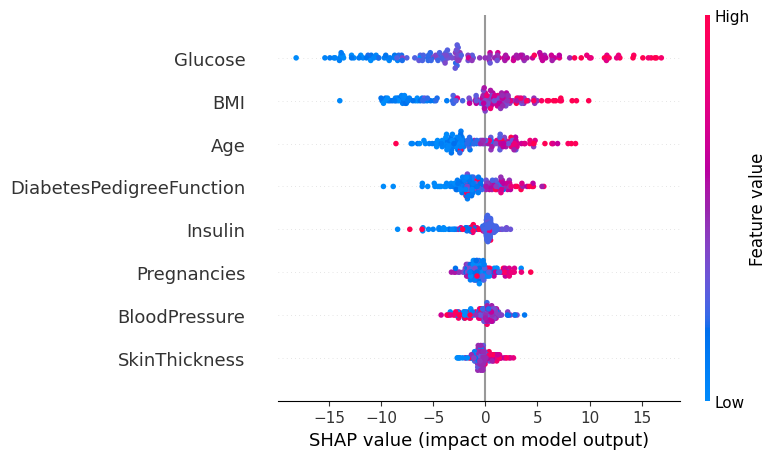

In [21]:
import shap
explainer=shap.TreeExplainer(best)
shap_values=explainer.shap_values(x_test_s)
shap.summary_plot(shap_values,x_test_s,feature_names=x.columns)

In [24]:
import joblib, json, os
os.makedirs("model", exist_ok=True)
joblib.dump(best, "model/diabetes_model.pkl")
joblib.dump(scaler, "model/scaler.pkl")
json.dump({"feature_order": x.columns.tolist()}, open("model/schema.json","w"))
from google.colab import files
files.download('model/diabetes_model.pkl')
files.download('model/scaler.pkl')
files.download('model/schema.json')



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>